In [7]:
%matplotlib inline
 
import pandas as pd
import numpy as np

# sklearn modules 
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
import plotly.express as px

import matplotlib.pyplot as plt



import warnings
warnings.filterwarnings('ignore')

 _______________________________________________
# Binary Classification - Rock & Jazz
## # echonest audio features
 _______________________________________________

# 1. Preprocessing

In [8]:
# load dataset
echo_popul = pd.read_csv('/Users/gaetanoantonicchio/Documents/GitHub/DataMining-2/src/Data (cleaned)/Datasets/dataset_song_popularity.csv')
popularity_labels = pd.read_csv('/Users/gaetanoantonicchio/Documents/GitHub/DataMining-2/src/Data (cleaned)/Labels/song_popularity_labels.csv')
echo_popul.set_index('track_id', inplace=True)
popularity_labels.set_index('track_id', inplace=True)
echo_popul = echo_popul.merge(popularity_labels, on='track_id')
echo_popul['bit_rate'] = echo_popul['bit_rate']//1000
echo_popul.head()

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,listens,bit_rate,song_popularity
track_id,,,,,,,,,,,
2,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,165.922,0.576661,1293,256,not popular
3,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,126.957,0.269240,514,256,not popular
5,0.043567,0.745566,0.701470,0.000697,0.373143,0.124595,100.260,0.621661,1151,256,not popular
10,0.951670,0.658179,0.924525,0.965427,0.115474,0.032985,111.562,0.963590,50135,192,popular
134,0.452217,0.513238,0.560410,0.019443,0.096567,0.525519,114.290,0.894072,943,256,not popular


In [9]:
pd.concat([echo_popul.song_popularity.value_counts(),
                round(echo_popul.song_popularity.value_counts(normalize=True).mul(100),2)],axis=1, keys=('counts','percentage (%)'))

,counts,percentage (%)
not popular,12399,94.44
popular,730,5.56


In [10]:
# encoding labels: 0 --> not popular,  1 --> popular
le = preprocessing.LabelEncoder()
echo_popul['song_popularity'] = le.fit_transform(echo_popul['song_popularity'])
print('legend:\n0: not popular\n1: popular')
echo_popul['song_popularity'].value_counts()

legend:
0: not popular
1: popular


0    12399
1      730
Name: song_popularity, dtype: int64

In [11]:
labels = echo_popul[['song_popularity']]
labels.reset_index(drop=True, inplace=True)
labels = labels['song_popularity']

In [12]:
echo_popul.drop('song_popularity', axis=1, inplace=True)

In [13]:
# normalize the dataset
scaler = StandardScaler()
scaled_features = scaler.fit_transform(echo_popul)

# 2. PCA on normalized data (scaled_features)
## 2.1 Determine optimal number of components
### a) scree-plot

Text(0.5, 0, 'Principal Component #')

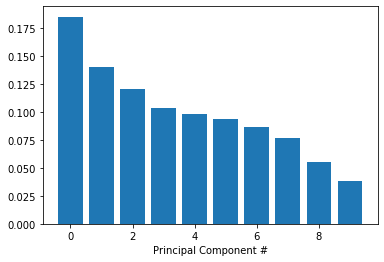

In [14]:
pca = PCA()
pca.fit(scaled_features)
# get explained variance ratios from PCA using all features
exp_variance = pca.explained_variance_ratio_
# plot explained variance
fig, ax= plt.subplots()
ax.bar(range(pca.n_components_),exp_variance)
ax.set_xlabel('Principal Component #')

### b) cumulative explained variance plot

Optimal number of components: 7
Explained variation per principal component:
[0.18542955 0.14066159 0.12086644 0.10386958 0.09811145 0.09387655
 0.08692574 0.07667427 0.05536938 0.03821545]


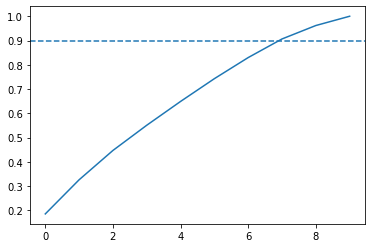

In [15]:
# calculate the cumulative explained variance
cum_exp_var = np.cumsum(exp_variance)
# plot the cumulative explained variance and draw a dashed line at 0.9\
# This line indicates how much variance (information) we want to retain
fig, ax= plt.subplots()
ax.plot(cum_exp_var)
ax.axhline(y=0.9, linestyle='--')

# find index where cum_exp_var exceeds 0.9 and adding 1 to that index to get the num of components
n_components = ((np.where(cum_exp_var > 0.9))[0][0])
print(f"Optimal number of components: {n_components}")
print(f"Explained variation per principal component:\n{pca.explained_variance_ratio_}")
# perform PCA with the chosen number of components and project data onto components
pca = PCA(n_components,random_state=10)
pca.fit(scaled_features)
pca_proj = pca.transform(scaled_features)

## 2.2 Plot PCA in 2D

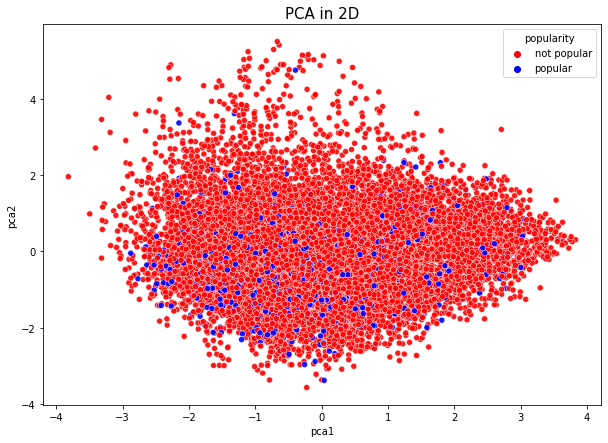

In [105]:
# generating df for plotting PCA
df = pd.DataFrame()
df['pca1'] = pca_proj[:,0]
df['pca2'] = pca_proj[:,1]
df['pca3'] = pca_proj[:,2] # for 3D plot
df['popularity'] = labels.apply(lambda x: "popular" if x==1 else "not popular")
# plot scatter of PCA
plt.figure(figsize=(10,7))
sns.scatterplot(
    x="pca1", y="pca2",
    hue='popularity',
    palette={'popular':'blue','not popular':'red'},
    data=df,
    legend="full",
    alpha=0.9
)
plt.title("PCA in 2D", fontsize= 15)
plt.show()

### 2.3 Plot PCA in 3D

In [106]:
# 3D PCA
#total_var = pca.explained_variance_ratio_.sum() * 100

fig = px.scatter_3d(
    df, x='pca1', y='pca2', z='pca3', color='popularity',
    #title=f'Total Explained Variance: {total_var:.2f}%',
    #labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'}
)
fig.update_layout(legend=dict(
    orientation="v",
    yanchor="bottom",
    y=1,
    xanchor="right",
    x=0.6
))
fig.show()

# 3. Split data for classification

In [16]:
# shuffle and split into development set and internal test set:
# (PCA)
Xpca_develop, Xpca_test, y_develop_pca, y_test_pca = train_test_split(
pca_proj, labels, test_size=0.30, random_state=42, stratify=labels)

# (split without PCA)
X_develop, X_test, y_develop, y_test = train_test_split(
scaled_features, labels, test_size=0.30, random_state=42,stratify= labels)

In [17]:
# check partition
print(f"___legend___\n0: not popular\n1: popular'\n\n***PCA***\nDevelopment set:\
\n{y_develop_pca.value_counts()}\n\nInternal Test:\n{y_test_pca.value_counts()}\n\n\
-----------------\n\
***No-PCA***\nDevelopment set:\n{y_develop.value_counts()}\n\nInternal Test:\n{y_test.value_counts()}")

___legend___
0: not popular
1: popular'

***PCA***
Development set:
0    8679
1     511
Name: song_popularity, dtype: int64

Internal Test:
0    3720
1     219
Name: song_popularity, dtype: int64

-----------------
***No-PCA***
Development set:
0    8679
1     511
Name: song_popularity, dtype: int64

Internal Test:
0    3720
1     219
Name: song_popularity, dtype: int64


# 4. Decision Tree
### a) Unbalanced - without PCA

#### - Validation Schema: coarse grid-search with repeated 5 fold CV
We adopt a 5 fold cross validation repeated 10 times and then averaged, in order to reduce the variance of the model.

In [109]:
# search parameters
param_grid = {
               "max_depth": [4,5,7,8,10],
               "min_samples_leaf": [10,15,25,35,55,75],
               "min_samples_split":[5,10,20,30],
               "criterion": ["gini", "entropy"]
             }

# instantiate a model
dtc = DecisionTreeClassifier()
rep_kfold = RepeatedKFold(n_splits=5, n_repeats=1, random_state=2652124)
clf = GridSearchCV(dtc, cv =rep_kfold , param_grid=param_grid, n_jobs=2, verbose=True)
clf.fit(X_develop, y_develop)
# display top model
print(f"best parameters:\n{clf.best_params_}\naccuracy: {clf.best_score_}")
#report(clf.cv_results_)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits
best parameters:
{'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 25, 'min_samples_split': 5}
accuracy: 0.9443960826985854


#### - Train and predict
The model is retrained on the full development set.

The prediction will be saved as:
- y_pred_dtc

The roc curve will be saved as:
- roc_auc0

The false and true positive rates will be saved as:
- fpr0
- tpr0

In [129]:
# train and fit
dtc = DecisionTreeClassifier(criterion= 'gini',max_depth=4, min_samples_leaf= 25, min_samples_split=5)
dtc.fit(X_develop,y_develop)
# predict on internal test set
y_pred_dtc = dtc.predict(X_test)

# display metrics
print('Accuracy %s' % accuracy_score(y_test, y_pred_dtc))
print('F1-score %s' % f1_score(y_test, y_pred_dtc, average=None))
print(classification_report(y_test, y_pred_dtc))

Accuracy 0.9444021325209444
F1-score [0.97140619 0.        ]
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      3720
           1       0.00      0.00      0.00       219

    accuracy                           0.94      3939
   macro avg       0.47      0.50      0.49      3939
weighted avg       0.89      0.94      0.92      3939



#### ROC Curve

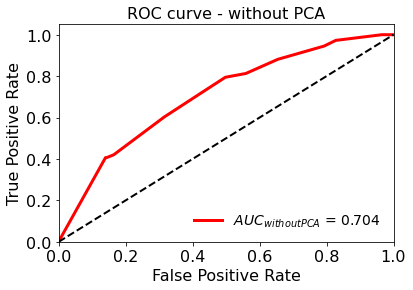

In [130]:
# y_score0 --> scores of decision tree without PCA
# fpr0, tpr0 ---> false positive and true positive of decision tree without PCA
y_score0 = dtc.predict_proba(X_test)
fpr0, tpr0, _ = roc_curve(y_test, y_score0[:, 1])

# roc_auc0 --> ROC/AUC of decision tree without PCA
roc_auc0 = auc(fpr0, tpr0)

plt.plot(fpr0, tpr0, color='red', lw=3, label='$AUC_{without PCA}$ = %.3f' % roc_auc0)

plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve - without PCA', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

#### Confusion Matrix

legend:
0: not popular
1: popular
[[3720    0]
 [ 219    0]]


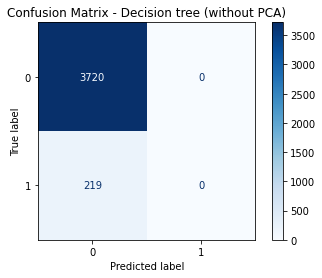

In [131]:
# confusion matrix - Internal Test
print('legend:\n0: not popular\n1: popular')
cm = plot_confusion_matrix(dtc,X_test,y_test,
                            cmap = plt.cm.Blues)
cm.ax_.set_title('Confusion Matrix - Decision tree (without PCA)')
print(cm.confusion_matrix)
plt.show()

### b) Unbalanced - with PCA
#### Validation schema:  repeated 5 fold cross validation - grid search

In [113]:
# model
dtc_pca = DecisionTreeClassifier()
rep_kfold = RepeatedKFold(n_splits=5, n_repeats=1, random_state=2652124)
clf = GridSearchCV(dtc, cv =rep_kfold , param_grid=param_grid, n_jobs=2, verbose=True)

clf.fit(Xpca_develop, y_develop_pca)
print(f"best parameters:\n{clf.best_params_}\naccuracy: {clf.best_score_}")

#report(clf.cv_results_)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits
best parameters:
{'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 10, 'min_samples_split': 30}
accuracy: 0.9443960826985854


#### - Train and predict
The model is retrained on the full development set.

The prediction will be saved as:
- y_pred_dtc_pca

The roc curve will be saved as:
- roc_auc1

The false and true positive rates will be saved as:
- fpr1
- tpr1

In [133]:
dtc_pca = DecisionTreeClassifier(criterion= 'gini',max_depth=4, min_samples_leaf= 10, min_samples_split=30)
dtc_pca.fit(Xpca_develop,y_develop_pca)

y_pred_dtc_pca = dtc_pca.predict(Xpca_test)

print('Accuracy %s' % accuracy_score(y_test_pca, y_pred_dtc_pca))
print('F1-score %s' % f1_score(y_test_pca, y_pred_dtc_pca, average=None))
print(classification_report(y_test_pca, y_pred_dtc_pca))

Accuracy 0.9444021325209444
F1-score [0.97140619 0.        ]
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      3720
           1       0.00      0.00      0.00       219

    accuracy                           0.94      3939
   macro avg       0.47      0.50      0.49      3939
weighted avg       0.89      0.94      0.92      3939



#### ROC curve

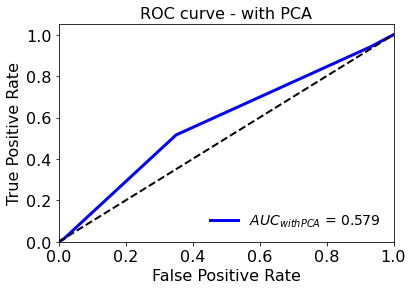

In [115]:
# y_score1 --> scores of decision tree with PCA
# fpr1, tpr1 ---> false positive and true positive of decision tree with PCA
y_score1 = dtc_pca.predict_proba(Xpca_test)
fpr1, tpr1, _ = roc_curve(y_test_pca, y_score1[:, 1])

# roc_auc1 --> ROC/AUC of decision tree with PCA
roc_auc1 = auc(fpr1, tpr1)

plt.plot(fpr1, tpr1, color='blue', lw=3, label='$AUC_{with PCA}$ = %.3f' % roc_auc1)

plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve - with PCA', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

#### Confusion matrix

Legend:
0: not popular
1: popular'
[[3720    0]
 [ 219    0]]


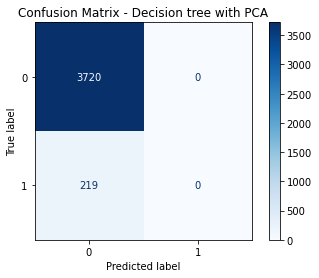

In [116]:
# confusion matrix Decision tree with PCA
print("Legend:\n0: not popular\n1: popular'")
cm_pca = plot_confusion_matrix(dtc_pca,Xpca_test,y_test_pca,
                            cmap = plt.cm.Blues)
cm_pca.ax_.set_title('Confusion Matrix - Decision tree with PCA')
print(cm_pca.confusion_matrix)
plt.show()

### c) Comparing Decision tree with and without PCA

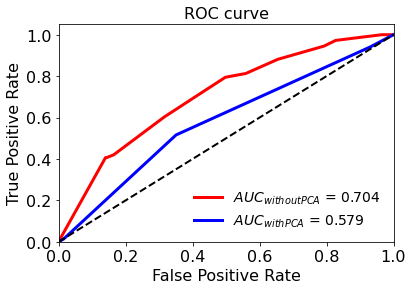

In [134]:
# ROC of decision tree without PCA
plt.plot(fpr0, tpr0, color='red', lw=3, label='$AUC_{without PCA}$ = %.3f' % roc_auc0)
# ROC of decision tree with PCA
plt.plot(fpr1, tpr1, color='blue', lw=3, label='$AUC_{with PCA}$ = %.3f' % roc_auc1)

plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

# 5. KNN
### a) Unbalanced - without PCA

#### Validation schema: coarse grid search with repeated 5 fold cross validation

In [118]:
# range of k to try - find a good range of k
k_range = {"n_neighbors":[x for x in range(2, 50)]}

knn = KNeighborsClassifier()
rep_kfold = RepeatedKFold(n_splits=5, n_repeats=1, random_state=2652124)
clf = GridSearchCV(knn, param_grid= k_range, cv=rep_kfold )
clf.fit(X_develop, y_develop)
print(f"best parameters:\n{clf.best_params_}\naccuracy: {clf.best_score_}")

#report(clf.cv_results_)

best parameters:
{'n_neighbors': 14}
accuracy: 0.9443960826985854


#### Train and predict

In [22]:
knn =  KNeighborsClassifier(n_neighbors = 12)
# retrain knn on the whole development set
knn.fit(X_develop, y_develop)
# predict target variable
y_pred_knn0 = knn.predict(X_test)

# display classification report
print(classification_report(y_test, y_pred_knn0))
print('legend:\n0: not popular\n1: popular')

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      3720
           1       0.00      0.00      0.00       219

    accuracy                           0.94      3939
   macro avg       0.47      0.50      0.49      3939
weighted avg       0.89      0.94      0.92      3939

legend:
0: not popular
1: popular


#### ROC curve

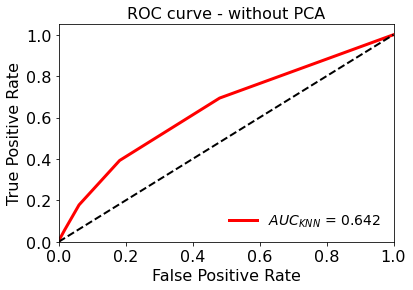

In [136]:
y_score_knn0 = knn.predict_proba(X_test)
fpr_knn0, tpr_knn0, _ = roc_curve(y_test, y_score_knn0[:, 1])
roc_auc_knn0 = auc(fpr_knn0, tpr_knn0)

plt.plot(fpr_knn0, tpr_knn0, color='red', lw=3, label='$AUC_{KNN}$ = %.3f' % roc_auc_knn0)

plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve - without PCA', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

#### Confusion matrix

legend:
0: not popular
1: popular
[[3720    0]
 [ 219    0]]


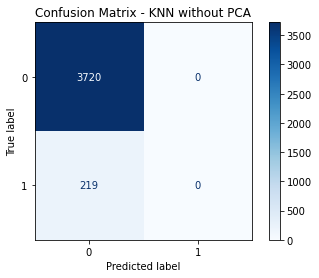

In [137]:
# confusion matrix KNN - Internal test
print('legend:\n0: not popular\n1: popular')
cm_knn = plot_confusion_matrix(knn,X_test,y_test,
                            cmap = plt.cm.Blues)
cm_knn.ax_.set_title('Confusion Matrix - KNN without PCA')
print(cm_knn.confusion_matrix)
plt.show()

### b) Unbalanced - with PCA

#### Validation schema: coarse grid search with repeated 5 fold cross validation

In [122]:
# range of k to try - find a good range of k
k_range = {"n_neighbors":[x for x in range(2, 50)]}

knn = KNeighborsClassifier()
rep_kfold = RepeatedKFold(n_splits=5, n_repeats=1, random_state=2652124)
clf = GridSearchCV(knn, param_grid= k_range, cv=rep_kfold )
clf.fit(Xpca_develop, y_develop_pca)
print(f"best parameters:\n{clf.best_params_}\naccuracy: {clf.best_score_}")

#report(clf.cv_results_)

best parameters:
{'n_neighbors': 12}
accuracy: 0.9443960826985854


#### Train and predict

In [138]:
knn_pca =  KNeighborsClassifier(n_neighbors = 12)
# retrain knn on the whole development set
knn_pca.fit(Xpca_develop, y_develop_pca)
# predict target variable
y_pred_knn1 = knn_pca.predict(Xpca_test)
# display classification report
print(classification_report(y_test_pca, y_pred_knn1))
print('legend:\n0: not popular\n1: popular')

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      3720
           1       0.00      0.00      0.00       219

    accuracy                           0.94      3939
   macro avg       0.47      0.50      0.49      3939
weighted avg       0.89      0.94      0.92      3939

legend:
0: not popular
1: popular


####  ROC curve

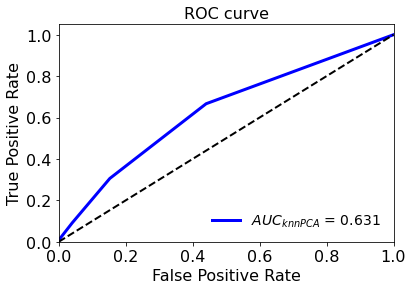

In [139]:
y_score_knn1 = knn_pca.predict_proba(Xpca_test)
fpr_knn1, tpr_knn1, _ = roc_curve(y_test_pca, y_score_knn1[:, 1])
roc_auc_knn1 = auc(fpr_knn1, tpr_knn1)

plt.plot(fpr_knn1, tpr_knn1, color='blue', lw=3, label='$AUC_{knnPCA}$ = %.3f' % roc_auc_knn1)

plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

#### Confusion matrix

legend:
0: not popular
1: popular
[[3720    0]
 [ 219    0]]


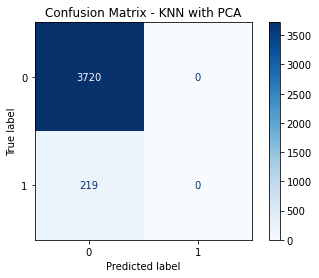

In [140]:
print('legend:\n0: not popular\n1: popular')
cm_knn_pca = plot_confusion_matrix(knn_pca,Xpca_test,y_test_pca,
                            cmap = plt.cm.Blues)
cm_knn_pca.ax_.set_title('Confusion Matrix - KNN with PCA')
print(cm_knn_pca.confusion_matrix)
plt.show()

### c) Comparing KNN with and without PCA

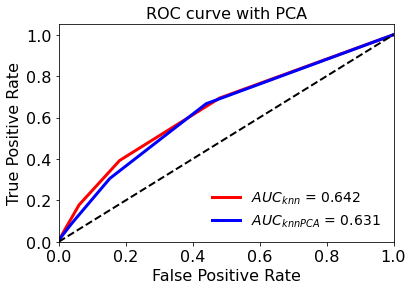

In [141]:
# ROC KNN without PCA
plt.plot(fpr_knn0, tpr_knn0, color='red', lw=3, label='$AUC_{knn}$ = %.3f' % roc_auc_knn0)
# ROC KNN with PCA
plt.plot(fpr_knn1, tpr_knn1, color='blue', lw=3, label='$AUC_{knnPCA}$ = %.3f' % roc_auc_knn1)

plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve with PCA', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

# Compare Decision tree and KNN (best scores)

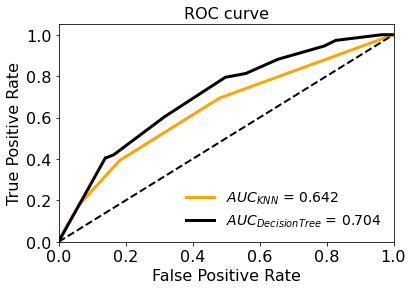

In [142]:
plt.plot(fpr_knn0, tpr_knn0, color='orange', lw=3, label='$AUC_{KNN}$ = %.3f' % roc_auc_knn0)
plt.plot(fpr0, tpr0, color='black', lw=3, label='$AUC_{DecisionTree}$ = %.3f' % roc_auc0)

plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()